In [100]:
library(ggplot2)
library(ggthemes)
library(gridExtra)

get_reoordered_df <- function(df){
    col_idx_homo <- grep("Number.of.Homozygotes", names(df))
    col_idx_hemi <- grep("Number.of.Hemizygotes", names(df))
    col_len <- length(names(df))
    
    return(df[, c(1:col_idx_homo,col_idx_hemi,(col_idx_homo+1):col_len)[-col_idx_hemi-1]])
}



get_pop_dfs <- function(df=NULL, freq_threshold=0.001){
    
    col_idx_alternative <- grep("Alternative", names(df))
    population_indexes <- c((col_idx_alternative+1):length(names(df)))
    
    populations_dfs <- c()
    i <- 1
    for (pop_idx in population_indexes){
        df_temp <- df[, c(1:col_idx_alternative,pop_idx)]
        populations_dfs[[i]] <- df_temp[df_temp[,ncol(df_temp)] > freq_threshold, ]
        i <- i + 1
    }
    
    return(populations_dfs)
}


get_pop_var_lists <- function(populations_dfs=NULL){
    
    pop_var_lists <- list()
    pop_names <- c()
    i <- 1
    for (pop in populations_dfs){
        
        pop_names[i] <- names(pop)[length(names(pop))]
        pop_var_lists[[i]] <- c(pop[,"Variant.ID"])
        i <- i+1
    }
    
    names(pop_var_lists) <- pop_names
    return(pop_var_lists)
}


keep_singles <- function(v){
  v[!(v %in% v[duplicated(v)])] 
}


get_number_of_vars <- function(pop_var_lists=NULL){
    all_vars <- unname(unlist(pop_var_lists, recursive = FALSE))
    unique <- keep_singles(all_vars)
    return(length(unique))
}

barplot_population_variants <- function(num_total, num_common, num_private, pop_name, pop_color, num_all_among_pops){
    
    if(num_all_among_pops == 0){
        num_all_among_pops = num_total
    }
    
    if (pop_name == "European..Finnish."){
        pop_name <- "Finnish"
    } else if (pop_name == "European..non.Finnish."){
        pop_name <- "European"
    }
    pop_name <- gsub("\\."," ",pop_name)
    
    
    value <- c(num_total, num_common, num_private, num_all_among_pops-num_total, 
               num_all_among_pops-num_common, num_all_among_pops-num_private)
    fill_to_high <- c("Value", "Value", "Value", "toHigh", "toHigh", "toHigh")
    legend <- c("Total", "Common", "Private", "Total", "Common", "Private")
    barplot_df <- data.frame(value,legend,fill_to_high)
    barplot_df$legend = factor(barplot_df$legend, levels = c("Total","Common","Private"))
    
    return(ggplot(barplot_df, aes(x = legend, y = value, fill=factor(fill_to_high, levels=c("toHigh","Value")))) + 
                geom_bar(stat = "identity", show.legend = FALSE, width=1, color='black', size=1.8) +
                scale_fill_manual(values = c("white",pop_color)) +
                labs(x="", y="") + 
                ggtitle(pop_name) +
                theme(plot.title = element_text(hjust = 0.5, size=15),
                      text = element_text(size=10, face="bold", family="AvantGarde"),
                      axis.line=element_blank(),
                      axis.text.x=element_text(color="black", margin=margin(t=-2, b=15)),
                      axis.text.y=element_blank(),
                      axis.ticks=element_blank(),
                      axis.title.x=element_blank(),
                      axis.title.y=element_blank(),
                      legend.position="none",
                      panel.background=element_blank(),
                      panel.border=element_blank(),
                      panel.grid.major=element_blank(),
                      panel.grid.minor=element_blank(),
                      plot.background=element_blank()))
}

get_all_plots <- function(pops_variants, pop_colors){
    
    num_all_among_pops <- get_number_of_vars(pops_vars)
    plot_list <- list()
    
    i <- 1
    for(pop in pops_variants){
        current_variants <- pop
        current_pop_name <- names(pops_variants)[i]
        all_other_variants <- unlist(unname(pops_variants[c(1:length(pops_variants))[-i]]))
        
        num_total <- length(current_variants)
        num_common <- length(intersect(current_variants, all_other_variants))
        num_private <- num_total-num_common 
        
        pop_plot <- barplot_population_variants(num_total, num_common, num_private, current_pop_name, 
                                                pop_colors[current_pop_name][[1]], num_all_among_pops)
        
        plot_list[[i]] <- pop_plot
        i <- i+1
    }
    
    return (plot_list)
}

pop_colors = c("darkgoldenrod2", "lightgoldenrod3", "darkgreen", "orangered3", "magenta4", 
               "royalblue4", "midnightblue", "lavenderblush4", "darkred", "tan4")
pop_names = c('African', 'Amish', 'Latino', 'Ashkenazi.Jewish',
              'East.Asian', 'European..Finnish.', 'European..non.Finnish.',
              'Other', 'South.Asian', 'Middle.Eastern')

names(pop_colors) = pop_names

In [101]:
df <- read.csv("test_data/ace2_tmprss2.csv")
df <- get_reoordered_df(df)
pop_dfs <- get_pop_dfs(df)
pops_vars <- get_pop_var_lists(pop_dfs)
num_unique_vars <- get_number_of_vars(pops_vars)

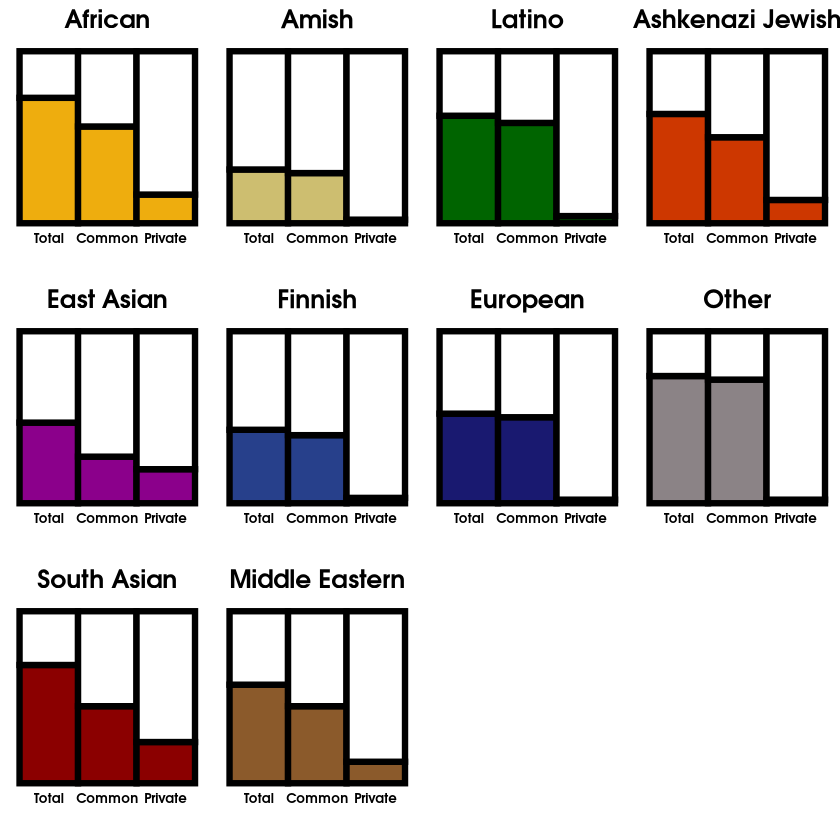

In [102]:
plot_list <- get_all_plots(pops_vars, pop_colors)
cowplot::plot_grid(plotlist = plot_list, align = "hv")

Saving 6.67 x 6.67 in image



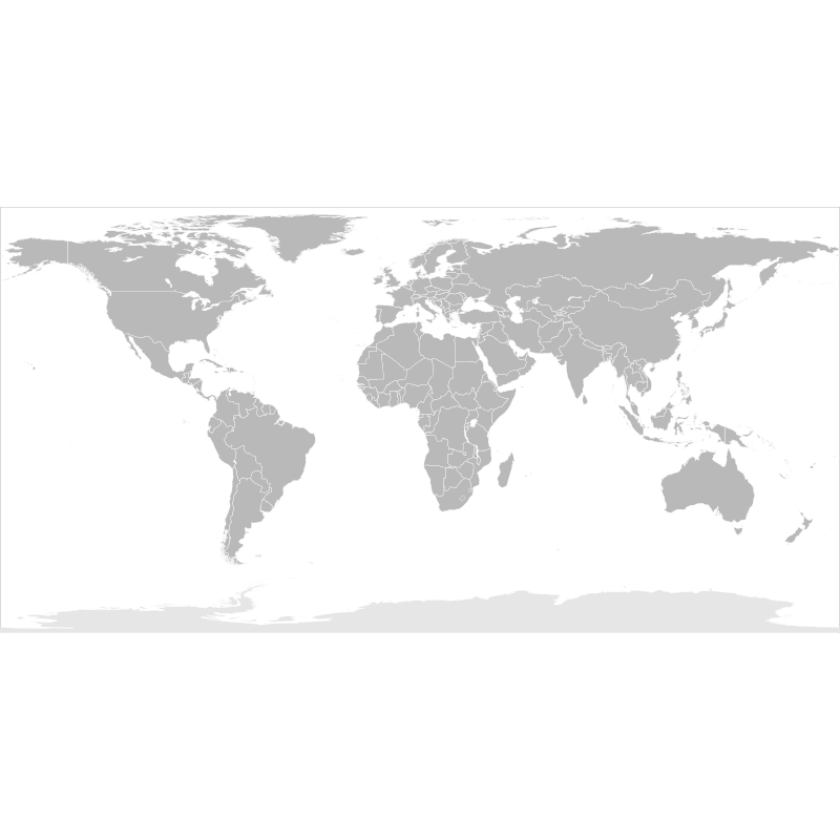

In [103]:
library(png)
library(grid)
ima <- readPNG("test_data/world_map.png")

tm <- theme(
    panel.background = element_rect(fill = "transparent",colour = "black"), 
    panel.grid.minor = element_blank(), 
    panel.grid.major = element_blank(),
    plot.background = element_rect(fill = "transparent",colour = NA)
)

plot.new()
g <- grid.raster(ima)
ggsave(filename="test_data/te.pdf", plot=g)

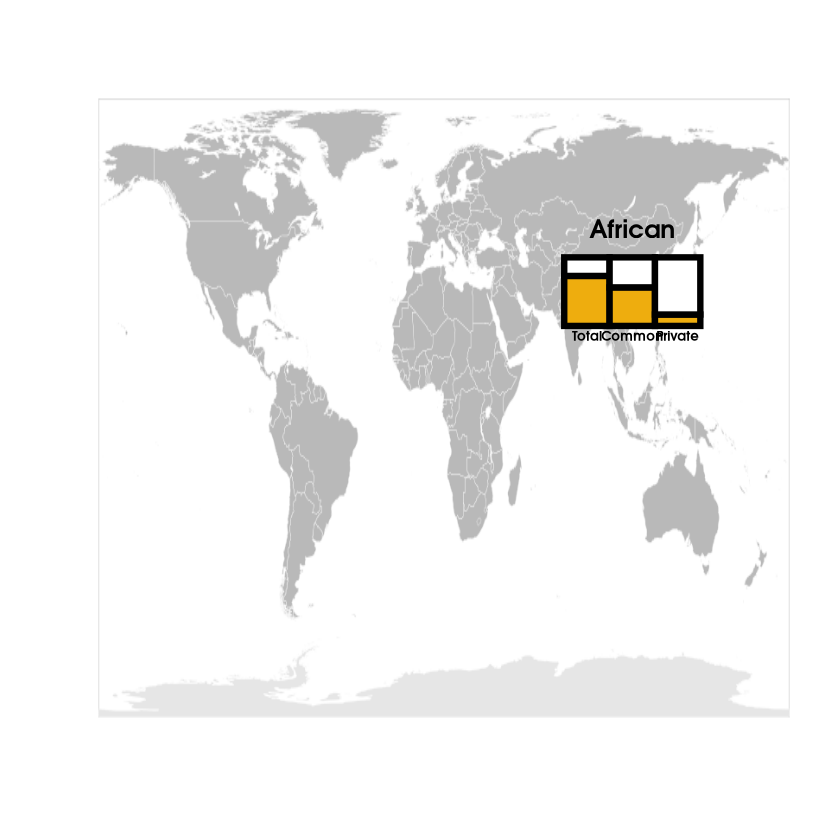

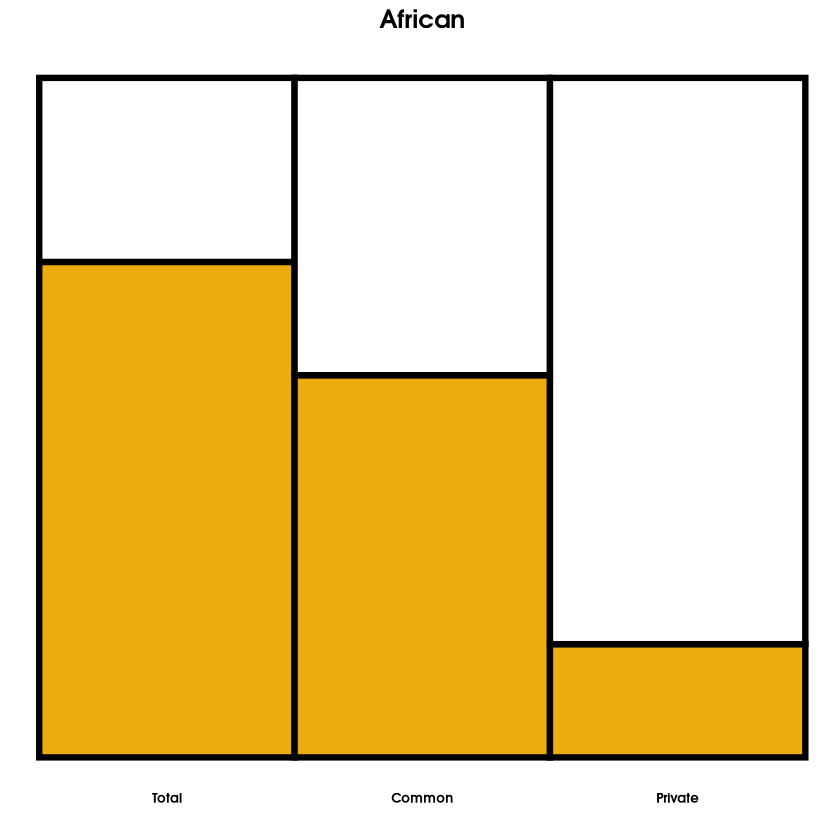

In [119]:
tm <- theme(
    panel.background = element_rect(fill = "transparent",colour = "black"), # or theme_blank()
    panel.grid.minor = element_blank(), 
    panel.grid.major = element_blank(),
    plot.background = element_rect(fill = "transparent",colour = NA)
)
plot.new()
lim <- par()
rasterImage(ima, lim$usr[1], lim$usr[3], lim$usr[2], lim$usr[4])

vp <- viewport(.75, 0.65, width =.2, height = .2)
a <- print(plot_list[[1]], vp = vp)
capture.output(a, file = "mapa.png")

In [122]:
lim[4]

$ann
[1] TRUE

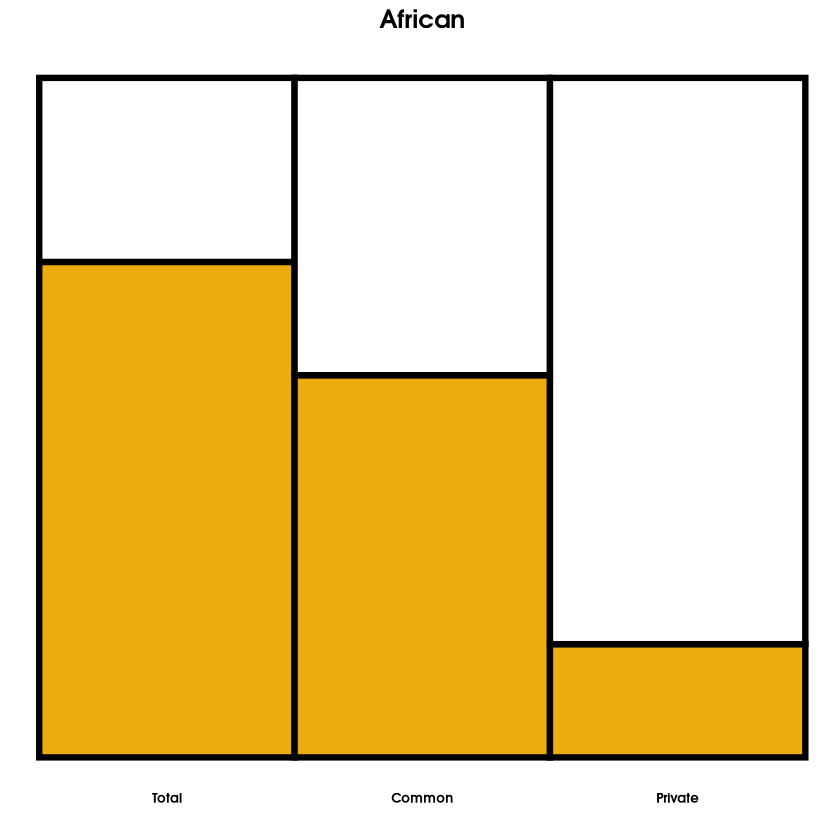

In [116]:
a

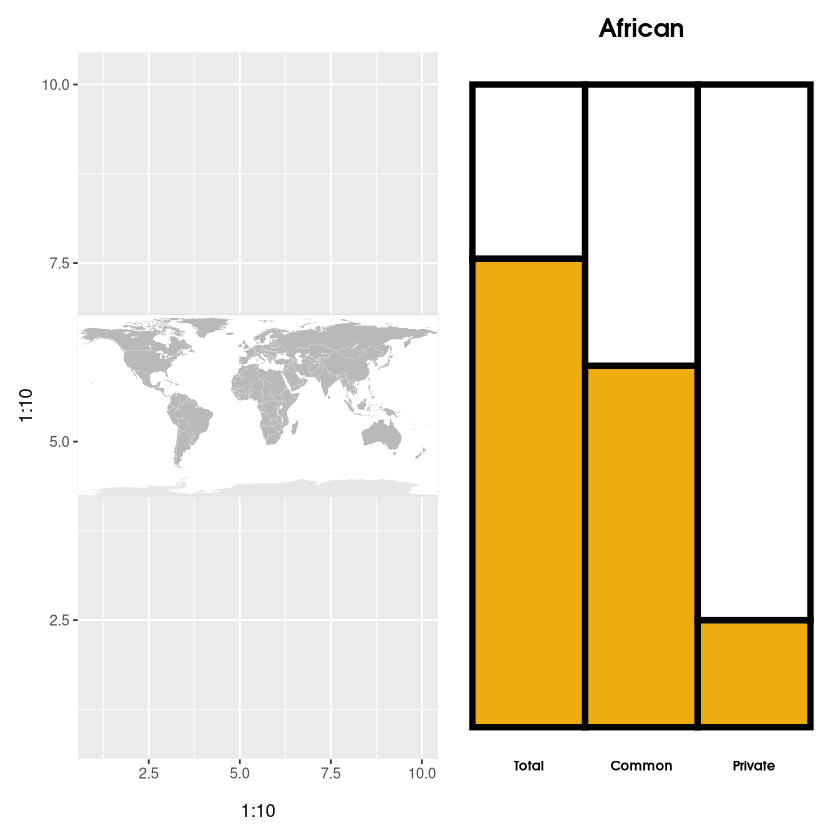

In [105]:
g <- rasterGrob(ima, interpolate=TRUE)

qplot(1:10, 1:10, geom="blank") +
  annotation_custom(g, xmin=-Inf, xmax=Inf, ymin=-Inf, ymax=Inf) +
    plot_list[1]

value,legend,fill_to_high
<int>,<fct>,<chr>
70,Total,Value
54,Common,Value
16,Private,Value
26,Total,toHigh
42,Common,toHigh
80,Private,toHigh


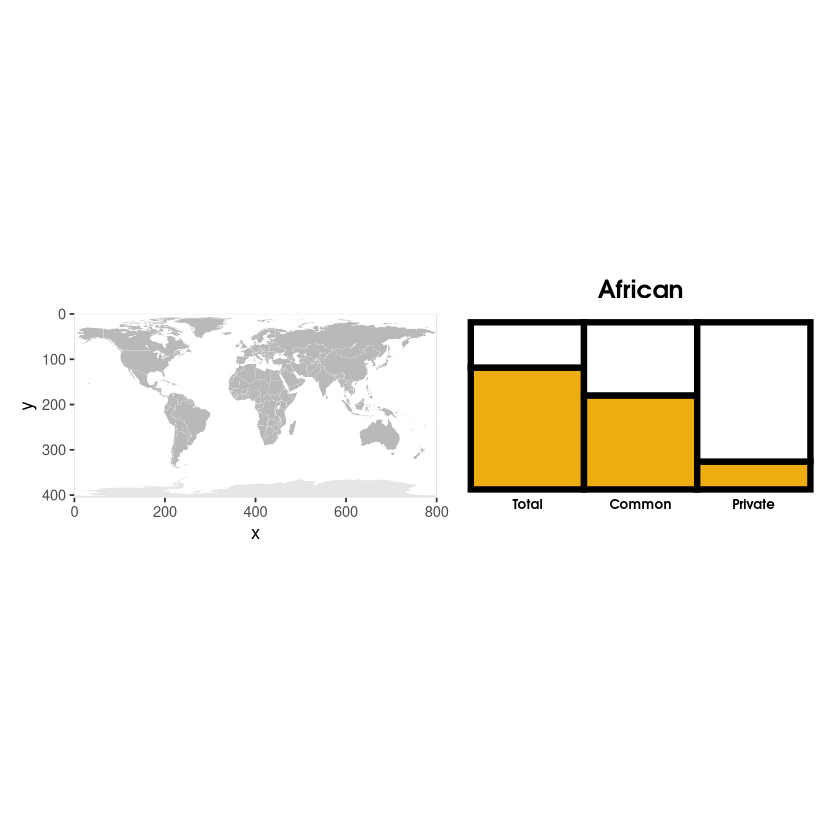

In [56]:
library(patchwork)
img <- ima

h<-dim(img)[1] # image height
w<-dim(img)[2] # image width

df<-data.frame(x=rnorm(100000,w/1.99,w/100),y=rnorm(100000,h/2.01,h/97))
plot(ggplot(df, aes(x,y)) + 
        annotation_custom(grid::rasterGrob(img, width=unit(1,"npc"), height=unit(1,"npc")), 0, w, 0, -h) + # The minus is needed to get the y scale reversed
        scale_x_continuous(expand=c(0,0),limits=c(0,w)) +
        scale_y_reverse(expand=c(0,0),limits=c(h,0)) + # The y scale is reversed because in image the vertical positive direction is typically downward
        # Also note the limits where h>0 is the first parameter.
        coord_equal() + # To keep the aspect ratio of the image.
     plot_list[[1]]
) 